# PAC-Bayesian Theory Meets Bayesian Inference

authors:

Ramón Daniel REGUEIRO ESPIÑO 
( ramondaniel1999@gmail.com )

María Magdalena SÁNCHEZ DEL RÍO AUFRERE DE LA PREUGNE
( srapmaria@gmail.com )

In [1]:
from bayesian_regression import BayesianRegression

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp

from matplotlib import rc
rc('text', usetex=True)

Bound parameters: a=1.000000, b=4.000000, s=0.529413, c=0.005000
Creating test data...
Creating training data...
Training on 10 datapoints...
Training on 17 datapoints...
Training on 31 datapoints...
Training on 56 datapoints...
Training on 100 datapoints...
Training on 177 datapoints...
Training on 316 datapoints...
Training on 562 datapoints...
Training on 1000 datapoints...
Training on 1778 datapoints...
Training on 3162 datapoints...
Training on 5623 datapoints...
Training on 10000 datapoints...
Training on 17782 datapoints...
Training on 31622 datapoints...
Training on 56234 datapoints...
Training on 100000 datapoints...
Training on 177827 datapoints...
Training on 316227 datapoints...
Training on 562341 datapoints...
Training on 1000000 datapoints...
Training on 1778279 datapoints...
Training on 3162277 datapoints...
Training on 5623413 datapoints...
Training on 10000000 datapoints...
done!


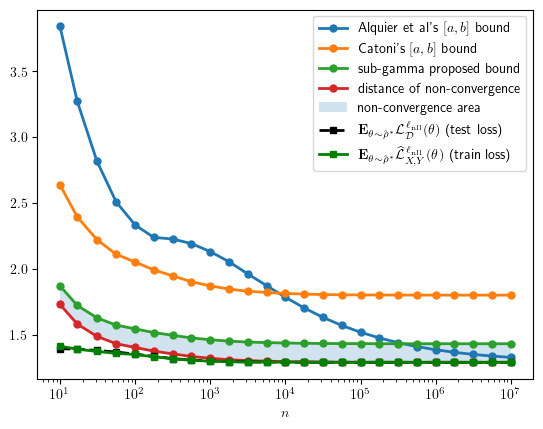

In [5]:
def main():
    np.random.seed(2023)

    nb_test = 150000
    nb_dim = 20
    noise = 1./3.
    sigma_prior = .1
    sigma_post = sqrt(2)
    w_norm = .5

    bound_param_a = 1.
    bound_param_b = 4.

    bound_param_c = (sigma_prior ** 2) / (sigma_post ** 2)
    bound_param_s = sqrt(nb_dim * sigma_prior**2 + w_norm**2 + (1 - bound_param_c) * noise**2) / sigma_post

    print("Bound parameters: a=%f, b=%f, s=%f, c=%f" % (bound_param_a, bound_param_b, bound_param_s, bound_param_c))

    assert bound_param_c < 1

    def create_data(n, _w=None):
        return create_linear_data(n, nb_dim, w=_w, sigma_noise=noise, w_norm=w_norm)

    print('Creating test data...')
    x_test, y_test, w_data = create_data(nb_test)

    nb_train_list = np.logspace(1, 7, 25, dtype=int)
    nb_params_train = len(nb_train_list)

    catoni_list, alquier_sqrt_list, subgamma_list,  train_loss_list, test_loss_list, kl_list,inf_bound_dif = [np.zeros(nb_params_train) for _ in range(7)]

    print('Creating training data...')
    x_all, y_all, _ = create_data(nb_train_list[-1], w_data)

    for i, nb_train in enumerate(nb_train_list):
        x, y = x_all[:nb_train, :], y_all[:nb_train]
        print('Training on %d datapoints...' % nb_train)
        clf = BayesianRegression(sigma_prior, sigma_post)
        clf.fit(x, y)

        train_loss_list[i] = clf.calc_gibbs_nll_loss(x, y)
        test_loss_list[i] = clf.calc_gibbs_nll_loss(x_test, y_test)

        kl_list[i] = clf.calc_kullback_leibler()
        alquier_sqrt_list[i] = bound_alquier_sqrt(train_loss_list[i], kl_list[i], nb_train, bound_param_a, bound_param_b)
        catoni_list[i] = bound_catoni(train_loss_list[i], kl_list[i], nb_train, bound_param_a, bound_param_b)
        subgamma_list[i] = bound_subgamma(train_loss_list[i], kl_list[i], nb_train, bound_param_s, bound_param_c)
        inf_bound_dif[i] = bound_dif(train_loss_list[i], kl_list[i], nb_train, bound_param_s, bound_param_c)

    print('done!')

    plt.semilogx(nb_train_list, alquier_sqrt_list, '-', linewidth=2, marker='o', markersize=5, label=r"Alquier et al's $[a,b]$ bound")
    plt.semilogx(nb_train_list, catoni_list, '-', linewidth=2, marker='o', markersize=5, label=r"Catoni's $[a,b]$ bound")
    plt.semilogx(nb_train_list, subgamma_list, '-', linewidth=2, marker='o', markersize=5, label=r"sub-gamma proposed bound")
    plt.semilogx(nb_train_list, inf_bound_dif, '-', linewidth=2, marker='o', markersize=5, label=r"distance of non-convergence")
    plt.fill_between(nb_train_list, inf_bound_dif, subgamma_list, alpha=0.2,label=r"non-convergence area")
    

    plt.semilogx(nb_train_list, test_loss_list, 'k--', linewidth=2, marker='s', markersize=5, label=r'$\mathbf{E}_{\theta\sim\hat\rho^*} \mathcal{L}_{\mathcal D}^{\,\ell_{\rm nll}}(\theta)$ (test loss)')
    plt.semilogx(nb_train_list, train_loss_list, 'g-', linewidth=2, marker='s', markersize=5, label=r'$\mathbf{E}_{\theta\sim\hat\rho^*} \widehat\mathcal{L}_{X,Y}^{\,\ell_{\rm nll}}(\theta)$ (train loss)')

    plt.xlabel('$n$')
    plt.legend()
    #plt.savefig('Area_non_convergence.pdf')
    plt.show()

def create_linear_data(n=100, d=10, sigma_x=1., w=None, w_norm=1., sigma_noise=0.1):
    if w is None:
        w = np.random.rand(d)
        w /= np.linalg.norm(w) / w_norm

    x = np.random.multivariate_normal(np.zeros(d), sigma_x ** 2 * np.eye(d), n) # Sample gaussian data
    noise = np.random.normal(scale=sigma_noise, size=n)
    y = np.dot(x, w) + noise
    return x, y, w

def bound_alquier_sqrt(loss, kl, n, a, b, delta=0.05):
    return loss + (1./sqrt(n)) * (kl - log(delta) + 0.5 * (b - a) ** 2)

def bound_catoni(loss, kl, n, a, b, delta=0.05):
    x = loss - a + (kl - log(delta)) / n
    z = (b - a) / (1-exp(a-b))
    return a + z * (1 - exp(-x))

def bound_subgamma(loss, kl, n, s, c, delta=0.05):
    return loss + (1./n) * (kl - log(delta)) + s ** 2 / (2*(1-c))

def bound_dif(loss, kl, n, s, c, delta=0.05):
    return loss + (1./n) * (kl - log(delta))

if __name__ == '__main__':
    main()